try:
    # settings colab:
    import google.colab
except ModuleNotFoundError:    
    # settings local:
    %run "../../../common/0_notebooks_base_setup.py"

---

<img src='../../../common/logo_DH.png' align='left' width=35%/>


## Ejercicios

En esta clase vamos entrenar distintos modelos de clasificación usando:
    
* Regresión Logística    

* KNN

* Classification Tree

* Random Forest


Para cada uno de ello vamos a evaluar la preformance en testing del modelo resultado

* Default

* Grid Search Cross Validation KFold

* Grid Search CV Stratified KFold

* Bagging

* Bagging Grid Search Cross Validation

Las métricas que vamos a calcular para cada modelo son

* score

* confusion matrix




## Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import auc, plot_roc_curve


## Ejercicio 1

1.1) Leamos los datos del archivo datasets_222487_478477_framingham.csv

1.2) ¿Qué porcentaje de registros hay en cada una de las categorías target?

1.3) ¿El dataset tiene datos faltantes?

1.4) Usemos `dropna` para eliminar los registros con valores faltantes, y volvamos a calcular el porcentaje de registros hay en cada una de las categorías target 

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html


In [3]:
data_raw = pd.read_csv('midi_stats_v3_drop_cols_.csv',sep=",")
data_raw.shape

(4833, 568)

In [4]:
data_raw.columns

Index(['Unnamed: 0', 'first_time_signature', 'cant_time_signatures', 'bpm',
       'compases', 'cant_dist_chords', 'avg_notes_quantified', 'tempo_changes',
       'tonalidad', 'tonalidad_escala',
       ...
       '('Distortion Guitar', 0.25)', '('Tom', 0.25)', '('Tom', 0.0)',
       '('Snare', 0.688)', '('Snare', 0.375)', '('Snare', 0.125)',
       '('Snare', 0.625)', '('Cencerro', 0.5)', '('Snare', 0.812)',
       '('Side Stick', 0.0)'],
      dtype='object', length=568)

Veamos qué procentaje de registros hay en cada una de las categorías target

In [5]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4833 entries, 0 to 4832
Columns: 568 entries, Unnamed: 0 to ('Side Stick', 0.0)
dtypes: float64(555), int64(6), object(7)
memory usage: 20.9+ MB


In [6]:
data = data_raw.fillna(value=0)
data.shape

(4833, 568)

Vemos que en este caso, eliminando los registros que tienen algun valor nulo no cambiamos la proporción de registros en cada una de las categorías target

In [7]:
data.loc[:,data.dtypes == object].head(1)

,first_time_signature,tonalidad,tonalidad_escala,info_tracks,Genero,Grupo,tema
0,3/4,F,M,untitled0 1 2 3 4 5,Classical,Bach,01 Menuet


In [8]:
data.drop(['info_tracks','Grupo','tema','Unnamed: 0'],inplace=True,axis=1)

In [9]:
data.loc[:,data.dtypes == object].head(1)

,first_time_signature,tonalidad,tonalidad_escala,Genero
0,3/4,F,M,Classical


In [10]:
data = pd.get_dummies(data, columns=['tonalidad','tonalidad_escala','first_time_signature'], prefix_sep='_', drop_first=True)

In [11]:
data.loc[:,data.dtypes == object].head(1)

,Genero
0,Classical


In [12]:
data.drop(data[data.cant_pedales_seg > 9999999].index,inplace=True)

In [13]:
data.shape

(4832, 600)

In [14]:
for col in data.loc[:,data.dtypes == np.float64].columns:
    data[col] = data[col].apply(lambda x: round(x,4))

## Ejercicio 2 - Train Test Split + StandardScaler

Construir los conjuntos de entranamiento y test y usando StandardScaler normalizar las features

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

In [15]:
X=data.drop(["Genero"],axis=1)
y=data["Genero"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=717, stratify=y)

bad_indices = np.where(np.isinf(X))

X.iloc[bad_indices[1][0]].head(50)


In [16]:
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

## De la práctica de checkpoint:

Vamos a usar esta función para entrenar todos los modelos que pide el enunciado, devolviendo como resultado las métricas de evaluación de cada modelo.

In [17]:
def evaluate_model(model_instance, X_train, y_train, X_test, y_test, gridSearch_params, gridSearch_bagging_params):
    
    # entreno el modelo default
    model_instance.fit(X_train, y_train)
    
    # calculo el score sobre los datos de test
    score_default_test = model_instance.score(X_test, y_test)
    
    # calculo la matriz de confusión
    predictions_default = model_instance.predict(X_test)
    confusion_matrix_default = metrics.confusion_matrix(y_test, predictions_default)
    
    ###################################################
    
    # gridSearch KFold:    
    cv_KFold = KFold(n_splits=3, shuffle=True, random_state=371)
    grid_search_CV_KFold_model = GridSearchCV(model_instance, gridSearch_params, n_jobs=-1, cv = cv_KFold)    
    grid_search_CV_KFold_model.fit(X_train, y_train)        
    scores_KFold = cross_val_score(model_instance, X_train, y_train, cv=cv_KFold, n_jobs=-1)
    mean_score_grid_search_CV_KFold_model = scores_KFold.mean()
    std_score_grid_search_CV_KFold_model = scores_KFold.std()
        
    score_grid_search_CV_KFold_model = grid_search_CV_KFold_model.best_score_
    params_grid_search_CV_KFold_model = grid_search_CV_KFold_model.best_params_
    
    score_grid_search_CV_KFold_model_test = grid_search_CV_KFold_model.score(X_test, y_test)
    predictions_grid_search_CV_KFold_model = grid_search_CV_KFold_model.predict(X_test)    
    confusion_matrix_grid_search_CV_KFold_model = metrics.confusion_matrix(y_test, predictions_grid_search_CV_KFold_model)

    ###################################################
    
    # gridSearch Stratified KFold:    
    cv_Stratified_KFold = StratifiedKFold(n_splits=3, shuffle=True, random_state=371)
    grid_search_CV_Stratified_KFold_model = GridSearchCV(model_instance, gridSearch_params, n_jobs=-1, cv = cv_Stratified_KFold)    
    grid_search_CV_Stratified_KFold_model.fit(X_train, y_train)        
    scores_Stratified_KFold = cross_val_score(model_instance, X_train, y_train, cv=cv_Stratified_KFold, n_jobs=-1)
    mean_score_grid_search_CV_Stratified_KFold_model = scores_Stratified_KFold.mean()
    std_score_grid_search_CV_Stratified_KFold_model = scores_Stratified_KFold.std()    
    
    score_grid_search_CV_Stratified_KFold_model = grid_search_CV_Stratified_KFold_model.best_score_
    params_grid_search_CV_Stratified_KFold_model = grid_search_CV_Stratified_KFold_model.best_params_
    
    score_grid_search_CV_Stratified_KFold_model_test = grid_search_CV_Stratified_KFold_model.score(X_test, y_test)
    predictions_grid_search_CV_Stratified_KFold_model = grid_search_CV_Stratified_KFold_model.predict(X_test)
    confusion_matrix_grid_search_CV_Stratified_KFold_model = metrics.confusion_matrix(y_test, predictions_grid_search_CV_Stratified_KFold_model)

    ###################################################
    
    if gridSearch_bagging_params:

        # bagging

        bagging_model_default = BaggingClassifier(base_estimator = model_instance)
        bagging_model_default.fit(X_train, y_train)
        score_bagging_model_default_test =  bagging_model_default.score(X_test, y_test)
        
        predictions_bagging_model_default = bagging_model_default.predict(X_test)
        confusion_matrix_bagging_model_default = metrics.confusion_matrix(y_test, predictions_bagging_model_default)    

        ###################################################

        # bagging Stratified KFold cross validation usando de base el mejor modelo de gridsearch estratificado
        base_estimator_stratified_grid_search = grid_search_CV_Stratified_KFold_model.best_estimator_
        cv_Stratified_KFold =StratifiedKFold(n_splits=3, shuffle=True, random_state=371)
        grid_search_bagging_model = GridSearchCV(BaggingClassifier(base_estimator = base_estimator_stratified_grid_search),
                               gridSearch_bagging_params, n_jobs=-1, cv = cv_Stratified_KFold)

        grid_search_bagging_model.fit(X_train, y_train)
        
        score_grid_search_bagging_model_test = grid_search_bagging_model.score(X_test, y_test)
        predictions_grid_search_bagging_model = grid_search_bagging_model.predict(X_test)
        confusion_matrix_grid_search_bagging_model = metrics.confusion_matrix(y_test, predictions_grid_search_bagging_model)
        scores_bagging_Stratified_KFold = cross_val_score(BaggingClassifier(base_estimator = base_estimator_stratified_grid_search),
                                                          X_train, y_train, cv=cv_Stratified_KFold, n_jobs=-1)
        mean_score_bagging_grid_search_CV_Stratified_KFold_model = scores_bagging_Stratified_KFold.mean()
        std_score_bagging_grid_search_CV_Stratified_KFold_model = scores_bagging_Stratified_KFold.std()    
        
        best_score_bagging_grid_search_CV_Stratified_KFold_model = grid_search_bagging_model.best_score_
        best_params_bagging_grid_search_CV_Stratified_KFold_model = grid_search_bagging_model.best_params_
    
    else:
        
        score_bagging_model_default_test = None
        confusion_matrix_bagging_model_default = None
        mean_score_bagging_grid_search_CV_Stratified_KFold_model = None
        std_score_bagging_grid_search_CV_Stratified_KFold_model = None
        confusion_matrix_grid_search_bagging_model = None
        best_score_bagging_grid_search_CV_Stratified_KFold_model = None
        score_grid_search_bagging_model_test = None
        best_params_bagging_grid_search_CV_Stratified_KFold_model = None

                                                                                                                                     
    ###################################################
    
    
    # armo un diccionario con todos los valores de performance que calculé para los modelos
    result = {
        'default': {
            'score': score_default_test,
            'confusion_matrix': confusion_matrix_default            
        },
        'cv_kfold': {
            'mean_score_grid_search': mean_score_grid_search_CV_KFold_model,
            'std_score_grid_search': std_score_grid_search_CV_KFold_model,
            'best_score_grid_search': score_grid_search_CV_KFold_model,
            'score': score_grid_search_CV_KFold_model_test,
            'confusion_matrix': confusion_matrix_grid_search_CV_KFold_model           
        },
        'cv_stratified_kfold': {
            'mean_score_grid_search': mean_score_grid_search_CV_Stratified_KFold_model,
            'std_score_grid_search': std_score_grid_search_CV_Stratified_KFold_model,
            'best_score_grid_search': score_grid_search_CV_Stratified_KFold_model,
            'score': score_grid_search_CV_Stratified_KFold_model_test,
            'confusion_matrix': confusion_matrix_grid_search_CV_Stratified_KFold_model           
        },
        'bagging': {
            'score': score_bagging_model_default_test,
            'confusion_matrix': confusion_matrix_bagging_model_default           
        },
        'bagging_cv_stratified_kfold': {
            'mean_score_grid_search': mean_score_bagging_grid_search_CV_Stratified_KFold_model,
            'std_score_grid_search': std_score_bagging_grid_search_CV_Stratified_KFold_model,
            'best_score_grid_search': best_params_bagging_grid_search_CV_Stratified_KFold_model,
            'score': score_grid_search_bagging_model_test,
            'confusion_matrix': confusion_matrix_grid_search_bagging_model           
        }
        
    }
    
    return result
        
#           'trained_model_instance': model_instance, 
#              'score_default': score_default_test,
#              'confusion_matrix_default': confusion_matrix_default,
#              'mean_score_grid_search_CV_KFold_model': mean_score_grid_search_CV_KFold_model, 
#              'std_score_grid_search_CV_KFold_model': std_score_grid_search_CV_KFold_model, 
#              'best_score_grid_search_CV_KFold_model': score_grid_search_CV_KFold_model,
#              'best_params_grid_search_CV_KFold_model': params_grid_search_CV_KFold_model,              
#              'score_grid_search_CV_KFold_model_test': score_grid_search_CV_KFold_model_test,
#              'confusion_matrix_grid_search_CV_KFold_model': confusion_matrix_grid_search_CV_KFold_model,
        
#              'mean_score_grid_search_CV_Stratified_KFold_model': mean_score_grid_search_CV_Stratified_KFold_model, 
#              'std_score_grid_search_CV_Stratified_KFold_model': std_score_grid_search_CV_Stratified_KFold_model, 
#              'best_score_grid_search_CV_Stratified_KFold_model': score_grid_search_CV_Stratified_KFold_model,
#              'best_params_grid_search_CV_Stratified_KFold_model': params_grid_search_CV_Stratified_KFold_model,              
#              'score_grid_search_CV_Stratified_KFold_model_test': score_grid_search_CV_Stratified_KFold_model_test,
#              'confusion_matrix_grid_search_CV_Stratified_KFold_model': confusion_matrix_grid_search_CV_Stratified_KFold_model,
        
#              'score_bagging_default': score_bagging_model_default_test,
#              'confusion_matrix_bagging_default': confusion_matrix_bagging_model_default,
        
#              'mean_score_bagging_grid_search_CV_Stratified_KFold_model': mean_score_bagging_grid_search_CV_Stratified_KFold_model, 
#              'std_score_bagging_grid_search_CV__StratifiedKFold_model': std_score_bagging_grid_search_CV_Stratified_KFold_model, 
#              'best_score_bagging_grid_search_CV_Stratified_KFold_model': best_score_bagging_grid_search_CV_Stratified_KFold_model,
#              'best_params_bagging_grid_search_CV_Stratified_KFold_model': best_params_bagging_grid_search_CV_Stratified_KFold_model,              
#              'score_bagging_grid_search_CV_Stratified_KFold_model_test': score_grid_search_bagging_model_test,
#              'confusion_matrix_bagging_grid_search_CV_Stratified_KFold_model': confusion_matrix_grid_search_bagging_model,

    
    
    
    
    

## Ejercicio 3 - Regresión Logística

Usemos la función definida en el checkpoint que evalua la performance de modelos en un modelo de regresión logística usando `LogisticRegression` con los parámetros por default

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

Los parámetros de GridSearchCV que vamos a probar son 

``params = {'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0], 'penalty': ['l1', 'l2']}``

Los parámetros de bagging que vamos a probar son

<code>
bagging_params = {'n_estimators': [10, 100],

                  'max_samples': [0.01, 1.0],
                  
                  'max_features': [0.3, 1.0],
                  
                  'bootstrap_features': [True, False]}
</code>



In [18]:
model_instance = LogisticRegression()
x_train = X_train_sc
x_test =  X_test_sc
gridSearch_params = {'C': [0, 1e-20, 1e-10, 1e-5, 1e-4, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0], 'penalty': ['l1', 'l2']}
gridSearch_bagging_params = {'n_estimators': [10, 100],
                  'max_samples': [0.01, 1.0],                  
                  'max_features': [0.3, 1.0],                  
                  'bootstrap_features': [True, False]}

logistic_metrics = evaluate_model(model_instance, x_train, y_train, x_test, y_test, gridSearch_params, gridSearch_bagging_params)

logistic_metrics

C:\Users\Patricio\anaconda3\envs\dhdsblend\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Patricio\anaconda3\envs\dhdsblend\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/mo

C:\Users\Patricio\anaconda3\envs\dhdsblend\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Patricio\anaconda3\envs\dhdsblend\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/mo

C:\Users\Patricio\anaconda3\envs\dhdsblend\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Patricio\anaconda3\envs\dhdsblend\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/mo

C:\Users\Patricio\anaconda3\envs\dhdsblend\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Patricio\anaconda3\envs\dhdsblend\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/mo

C:\Users\Patricio\anaconda3\envs\dhdsblend\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Patricio\anaconda3\envs\dhdsblend\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/mo

C:\Users\Patricio\anaconda3\envs\dhdsblend\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Patricio\anaconda3\envs\dhdsblend\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/mo

C:\Users\Patricio\anaconda3\envs\dhdsblend\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Patricio\anaconda3\envs\dhdsblend\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/mo

C:\Users\Patricio\anaconda3\envs\dhdsblend\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Patricio\anaconda3\envs\dhdsblend\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/mo

{'default': {'score': 0.886896551724138,
  'confusion_matrix': array([[553,   3,   5,   0,   3,   2,   9,   3,   2,   2,   1,  25],
         [  3, 426,   0,   0,   0,   0,   3,   0,   0,   0,   1,   0],
         [  5,   0,   1,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   2,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,  97,   0,   0,   0,   0,   0,   0,   0],
         [  2,   0,   0,   0,   0,  90,   0,   0,   0,   1,   0,   1],
         [  8,   4,   0,   0,   1,   0,  36,   0,   0,   0,   0,   2],
         [ 12,   1,   0,   0,   0,   0,   0,  10,   0,   0,   0,   0],
         [  9,   0,   0,   0,   0,   1,   0,   0,   1,   0,   0,   2],
         [  1,   1,   0,   0,   0,   2,   1,   0,   0,  11,   0,   5],
         [  1,   2,   0,   0,   0,   0,   0,   0,   0,   0,  21,   0],
         [ 28,   2,   0,   0,   0,   1,   3,   1,   1,   3,   1,  38]],
        dtype=int64)},
 'cv_kfold': {'mean_score_grid_search': 0.8766988448169893,
  '

(Para todos los modelos vamos a ver que la capacidad de predicción de la clase minoritaria es bastante mala)

## Ejercicio 4 - KNN

Usemos la función definida en el checkpoint que evalua la performance de modelos en un modelo KNN usando `KNeighborsClassifier` con los parámetros por default (n_neighbors=5)

https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

Los parámetros de GridSearchCV que vamos a probar son 

``params =  {'n_neighbors': range(1,50)}``

Los parámetros de bagging que vamos a probar son

<code>
bagging_params = {'n_estimators': [10, 100],

                  'max_samples': [0.05, 1.0],
                  
                  'max_features': [0.3, 1.0],
                  
                  'bootstrap_features': [True, False]}
</code>



In [19]:
model_instance = KNeighborsClassifier()
x_train = X_train_sc
x_test =  X_test_sc
gridSearch_params = {'n_neighbors': range(1,50)}
gridSearch_bagging_params = {'n_estimators': [10, 100],
                  'max_samples': [0.05, 1.0],                  
                  'max_features': [0.3, 1.0],                  
                  'bootstrap_features': [True, False]}

knn_metrics = evaluate_model(model_instance, x_train, y_train, x_test, y_test, gridSearch_params, gridSearch_bagging_params)

knn_metrics

{'default': {'score': 0.7958620689655173,
  'confusion_matrix': array([[470, 106,   0,   0,  11,   3,   7,   1,   0,   0,   0,  10],
         [  4, 423,   0,   0,   0,   0,   3,   0,   0,   0,   3,   0],
         [  4,   1,   0,   0,   0,   0,   0,   0,   1,   0,   0,   0],
         [  1,   0,   0,   0,   0,   0,   0,   1,   0,   0,   0,   0],
         [  0,   3,   0,   0,  94,   0,   0,   0,   0,   0,   0,   0],
         [  4,   1,   0,   0,   0,  89,   0,   0,   0,   0,   0,   0],
         [  8,  15,   0,   0,   2,   0,  25,   0,   0,   0,   1,   0],
         [ 14,   1,   0,   0,   0,   0,   0,   8,   0,   0,   0,   0],
         [ 12,   1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  8,   0,   0,   0,   0,   2,   1,   0,   0,   9,   0,   1],
         [  0,   5,   0,   0,   0,   0,   0,   0,   0,   0,  19,   0],
         [ 47,  12,   0,   0,   1,   1,   0,   0,   0,   0,   0,  17]],
        dtype=int64)},
 'cv_kfold': {'mean_score_grid_search': 0.7853306755943205,
  

## Ejercicio 5 - Tree

Usemos la función definida en el checkpoint que evalua la performance de modelos en un modelo de árbol de decisión usando `DecisionTreeClassifier` con los parámetros por default

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

Los parámetros de GridSearchCV que vamos a probar son 

``params =  {'criterion': ['gini', 'entropy'],
          'splitter': ['best', 'random'],
          'max_depth': [None, 5, 10],
          'min_samples_split': [2, 5],
          'min_samples_leaf': [1, 2, 3]}``

Los parámetros de bagging que vamos a probar son

<code>
bagging_params = {'n_estimators': [10, 100],

                  'max_samples': [0.01, 1.0],
                  
                  'max_features': [0.3, 1.0],
                  
                  'bootstrap_features': [True, False]}
</code>


In [20]:
model_instance = DecisionTreeClassifier()
x_train = X_train_sc
x_test =  X_test_sc
gridSearch_params = {'criterion': ['gini', 'entropy'],
          'splitter': ['best', 'random'],
          'max_depth': [None, 5, 10],
          'min_samples_split': [2, 5],
          'min_samples_leaf': [1, 2, 3]}

gridSearch_bagging_params = {'n_estimators': [10, 100],
                  'max_samples': [0.01, 1.0],                  
                  'max_features': [0.3, 1.0],                  
                  'bootstrap_features': [True, False]}

decision_tree_metrics = evaluate_model(model_instance, x_train, y_train, x_test, y_test, gridSearch_params, gridSearch_bagging_params)

decision_tree_metrics

{'default': {'score': 0.8351724137931035,
  'confusion_matrix': array([[515,   5,   4,   2,   2,  12,  13,  13,   6,   6,   1,  29],
         [ 12, 412,   0,   0,   1,   0,   6,   0,   0,   0,   1,   1],
         [  2,   0,   0,   0,   0,   0,   1,   2,   1,   0,   0,   0],
         [  1,   0,   0,   1,   0,   0,   0,   0,   0,   0,   0,   0],
         [  2,   3,   0,   0,  91,   0,   1,   0,   0,   0,   0,   0],
         [  5,   0,   0,   0,   0,  85,   2,   0,   1,   0,   1,   0],
         [  8,   7,   0,   0,   1,   0,  33,   0,   1,   0,   0,   1],
         [ 18,   0,   1,   0,   0,   0,   1,   3,   0,   0,   0,   0],
         [  6,   0,   0,   0,   0,   1,   3,   0,   3,   0,   0,   0],
         [  1,   1,   0,   0,   0,   2,   0,   0,   0,  15,   0,   2],
         [  0,   4,   0,   0,   0,   0,   1,   0,   0,   0,  19,   0],
         [ 30,   2,   0,   0,   0,   4,   2,   0,   2,   2,   2,  34]],
        dtype=int64)},
 'cv_kfold': {'mean_score_grid_search': 0.8196340207374965,
  

## Ejercicio 6 - Random Forest

Usemos la función definida en el checkpoint que evalua la performance de modelos en un modelo random forest usando `RandomForestClassifier` con los parámetros por default

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

Los parámetros de GridSearchCV que vamos a probar son 

``params =   {'n_estimators':[3, 5, 10, 50],
          'criterion': ['gini', 'entropy'],
          'max_depth': [None, 3, 5],
          'min_samples_split': [2,5],
          'class_weight':[None, 'balanced']}``

(No vamos a hacer bagging sobre este modelo porque ya es un ensamble.)

In [21]:
model_instance = RandomForestClassifier()
x_train = X_train_sc
x_test =  X_test_sc
gridSearch_params = {'n_estimators':[3, 5, 10, 50],
          'criterion': ['gini', 'entropy'],
          'max_depth': [None, 3, 5],
          'min_samples_split': [2,5],
          'class_weight':[None, 'balanced']}

gridSearch_bagging_params = None

random_forest_metrics = evaluate_model(model_instance, x_train, y_train, x_test, y_test, gridSearch_params, gridSearch_bagging_params)

random_forest_metrics

{'default': {'score': 0.8931034482758621,
  'confusion_matrix': array([[598,   3,   2,   0,   1,   0,   1,   0,   0,   0,   0,   3],
         [  0, 431,   0,   0,   0,   0,   2,   0,   0,   0,   0,   0],
         [  6,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  1,   0,   0,   1,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,  97,   0,   0,   0,   0,   0,   0,   0],
         [  5,   0,   0,   0,   0,  89,   0,   0,   0,   0,   0,   0],
         [ 13,  10,   0,   0,   0,   0,  28,   0,   0,   0,   0,   0],
         [ 17,   1,   0,   0,   0,   0,   0,   5,   0,   0,   0,   0],
         [ 13,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  4,   2,   0,   0,   0,   2,   0,   0,   0,  10,   0,   3],
         [  2,   4,   0,   0,   0,   0,   0,   0,   0,   0,  18,   0],
         [ 58,   2,   0,   0,   0,   0,   0,   0,   0,   0,   0,  18]],
        dtype=int64)},
 'cv_kfold': {'mean_score_grid_search': 0.8793618279874392,
  

## Ejercicio 7 - Evaluación de modelos

Vamos a comparar los resultados de los diferentes modelos. Para eso, grafiquemos como barras los scores de los modelos evaluados en el conjunto de testing. 

¿Cuál es el ganador?

Repetir el gráfico mostrando el valor medio el desvío estandard de la validación cruzada. ¿Es el mismo ganador?


default 0.886896551724138


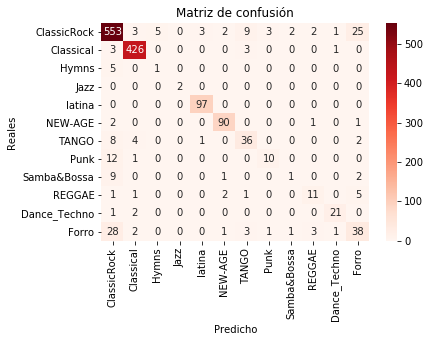

cv_kfold 0.9082758620689655


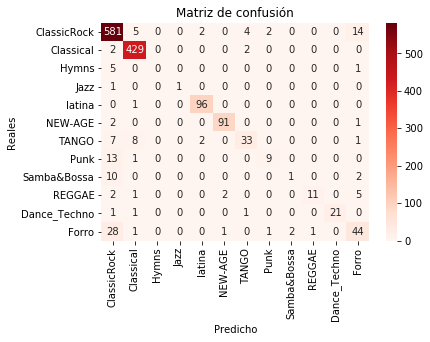

cv_stratified_kfold 0.8931034482758621


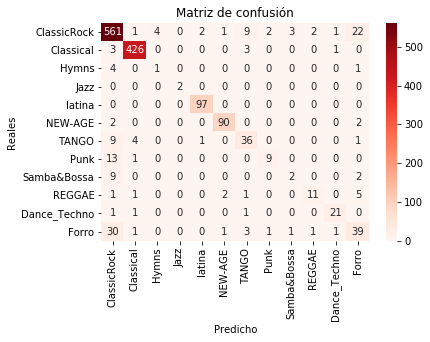

bagging 0.8979310344827586


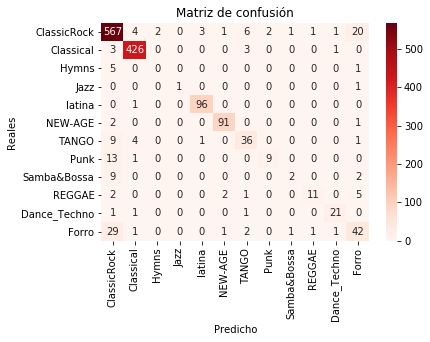

bagging_cv_stratified_kfold 0.9144827586206896


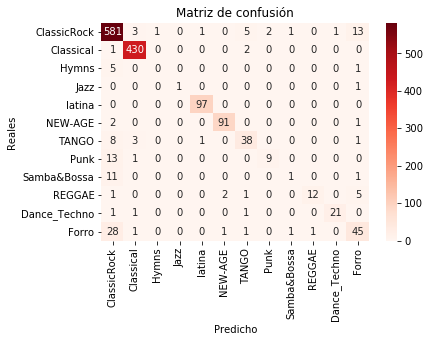

default 0.7958620689655173


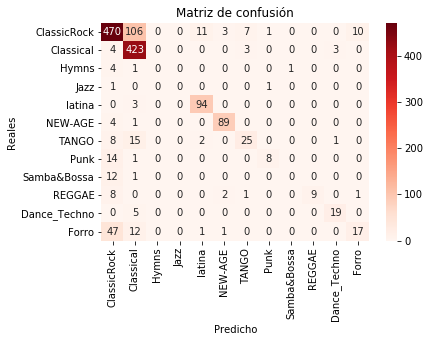

cv_kfold 0.8103448275862069


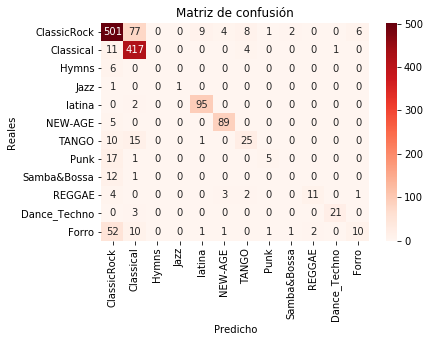

cv_stratified_kfold 0.8103448275862069


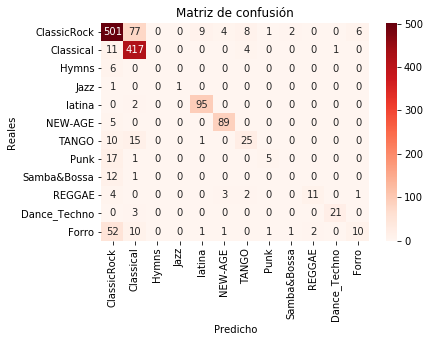

bagging 0.7841379310344827


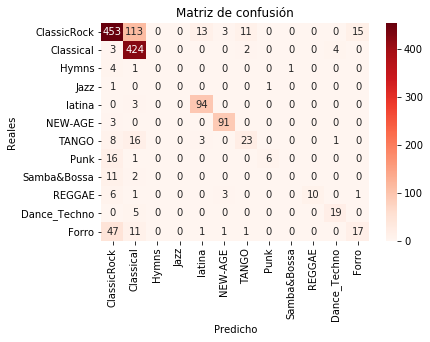

bagging_cv_stratified_kfold 0.86


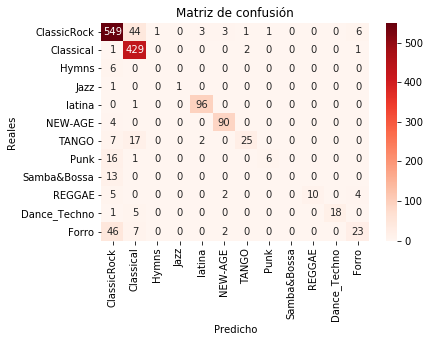

default 0.8351724137931035


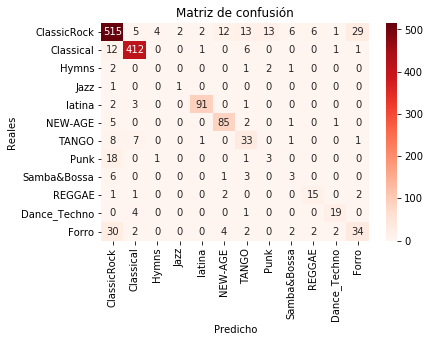

cv_kfold 0.8551724137931035


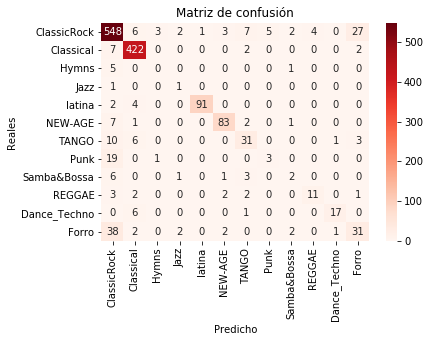

cv_stratified_kfold 0.8517241379310345


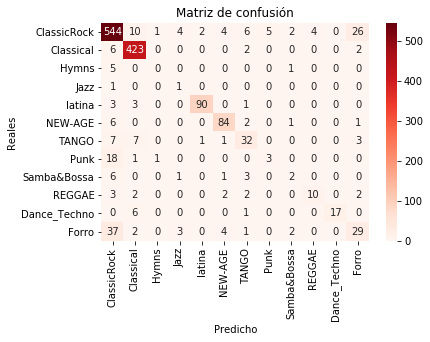

bagging 0.8944827586206896


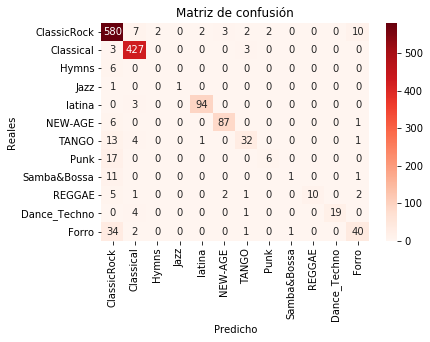

bagging_cv_stratified_kfold 0.8917241379310344


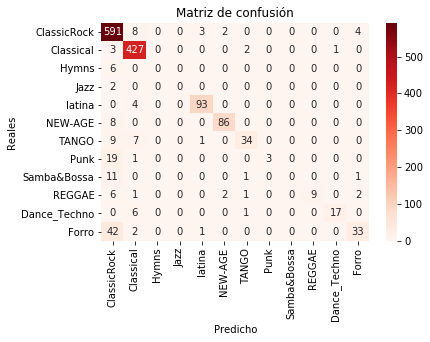

default 0.8931034482758621


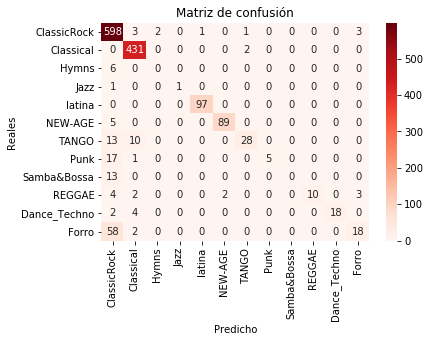

cv_kfold 0.8944827586206896


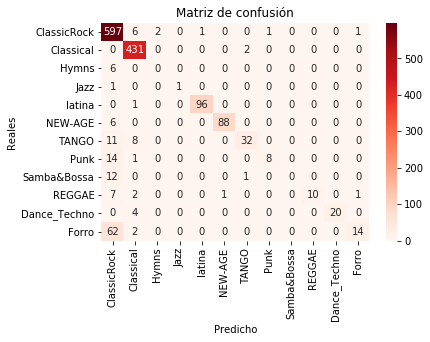

cv_stratified_kfold 0.896551724137931


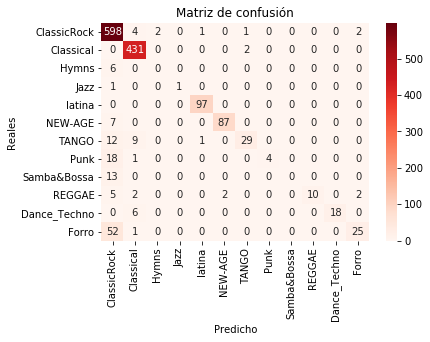

bagging None


ValueError: Must pass 2-d input

In [22]:
import seaborn as sns
labels_gender = data.Genero.value_counts().index

all_model_metrics = [logistic_metrics, knn_metrics, decision_tree_metrics, random_forest_metrics]
all_model_names =  ['logistic', 'knn', 'decision_tree', 'random_forest']

data_to_plot = pd.DataFrame(columns = ['model', 'score'])
data_to_plot

for i in range(len(all_model_names)):
    model_name_prefix = all_model_names[i]
    model_metric = all_model_metrics[i]        
    for model_metric_key in model_metric.keys():    
        score = model_metric[model_metric_key]['score'] 
        print(model_metric_key, score)
        ax = sns.heatmap(model_metric[model_metric_key]['confusion_matrix'], annot = True, cmap = 'Reds', fmt = 'd',xticklabels=labels_gender,yticklabels=labels_gender)
        ax.set(xlabel = 'Predicho', ylabel = 'Reales')
        plt.title('Matriz de confusión')
        plt.show()
        data_to_plot = data_to_plot.append({'model': model_name_prefix + '_' + model_metric_key, 'score':score}, ignore_index=True)
        
data_to_plot.index = data_to_plot.model

data_to_plot.sort_values(by = 'score', axis=0, ascending=True, inplace=True)


(0.7, 0.9)

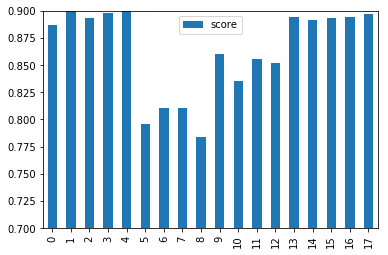

In [23]:
data_to_plot.plot(kind='bar')
plt.ylim(0.7, 0.9)


In [24]:
data_to_plot_cv = pd.DataFrame(columns = ['model', 'score', 'error'])

for i in range(len(all_model_names)):
    model_name_prefix = all_model_names[i]
    model_metric = all_model_metrics[i]        
    for model_metric_key in model_metric.keys():    
        model = model_metric[model_metric_key]
        if 'mean_score_grid_search' in model.keys() and 'std_score_grid_search' in model.keys():
            score = model['mean_score_grid_search']        
            std = model['std_score_grid_search']        
            data_to_plot_cv = data_to_plot_cv.append({'model': model_name_prefix + '_' + model_metric_key, 
                                            'score':score,
                                            'error': std,
                                           }, ignore_index=True)
        
data_to_plot_cv.index = data_to_plot_cv.model

data_to_plot_cv.sort_values(by = 'score', axis=0, ascending=True, inplace=True)

In [25]:
data_to_plot_cv

,model,score,error
model,,,
knn_cv_kfold,knn_cv_kfold,0.785331,0.008438
knn_cv_stratified_kfold,knn_cv_stratified_kfold,0.785922,0.010912
knn_bagging_cv_stratified_kfold,knn_bagging_cv_stratified_kfold,0.789769,0.010529
decision_tree_cv_stratified_kfold,decision_tree_cv_stratified_kfold,0.803079,0.010185
decision_tree_cv_kfold,decision_tree_cv_kfold,0.819634,0.006713
decision_tree_bagging_cv_stratified_kfold,decision_tree_bagging_cv_stratified_kfold,0.871378,0.001200
logistic_cv_kfold,logistic_cv_kfold,0.876699,0.003367
random_forest_cv_stratified_kfold,random_forest_cv_stratified_kfold,0.876995,0.002774
random_forest_cv_kfold,random_forest_cv_kfold,0.879362,0.001405


(0.7, 0.9)

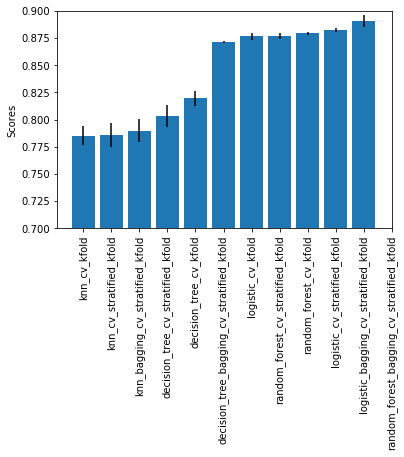

In [26]:
fig, ax = plt.subplots()
x_values = range(data_to_plot_cv.shape[0])
y_values = data_to_plot_cv.score
rects1 = ax.bar(x_values, y_values,
                yerr=data_to_plot_cv.error,
                tick_label=data_to_plot_cv.index)

ax.set_ylabel('Scores')
plt.xticks(rotation=90)
plt.ylim(0.7, 0.9)

In [27]:
y_values

model
knn_cv_kfold                                 0.785331
knn_cv_stratified_kfold                      0.785922
knn_bagging_cv_stratified_kfold              0.789769
decision_tree_cv_stratified_kfold            0.803079
decision_tree_cv_kfold                       0.819634
decision_tree_bagging_cv_stratified_kfold    0.871378
logistic_cv_kfold                            0.876699
random_forest_cv_stratified_kfold            0.876995
random_forest_cv_kfold                       0.879362
logistic_cv_stratified_kfold                 0.882615
logistic_bagging_cv_stratified_kfold         0.890599
random_forest_bagging_cv_stratified_kfold         NaN
Name: score, dtype: float64

## Ejercicio 8 - Importancia de features

Veamos ahora la cuál es la importancia de cada variable predictora en el modelo random forest

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier.feature_importances_

Representemos en un gráfico de barras la importancia de cada una, y su error definido como el desvío estandar de las importancias de cada variable sobre todos los árboles.


In [28]:
random_forest = RandomForestClassifier()
random_forest.fit(X_train_sc, y_train)
feature_importance = random_forest.feature_importances_
feature_importance

array([8.39407730e-04, 6.09635871e-03, 7.59743000e-03, 4.98448297e-03,
       8.45376414e-03, 4.39609336e-03, 7.93389664e-03, 3.39703265e-03,
       2.62687676e-03, 8.61461272e-03, 2.76399898e-03, 1.74640861e-03,
       1.64292146e-03, 2.13157642e-03, 1.41643045e-03, 3.43153457e-03,
       9.40019864e-03, 4.41463907e-03, 1.38408464e-02, 6.55427293e-03,
       1.05296744e-02, 5.82680051e-03, 9.35675177e-03, 6.50611432e-03,
       5.83079992e-03, 1.02236088e-02, 4.48525800e-03, 2.87402599e-03,
       9.15687987e-03, 5.64127528e-03, 7.23171162e-03, 4.06088191e-03,
       4.69047221e-03, 1.64670656e-03, 1.05115631e-03, 1.57033314e-03,
       2.74794273e-03, 6.56834295e-03, 3.54531729e-03, 4.19789200e-03,
       4.15432996e-03, 5.43549928e-03, 4.55867274e-03, 3.31203052e-03,
       3.25237453e-03, 8.79240829e-03, 3.86375366e-03, 3.58722889e-03,
       2.44663422e-03, 4.72199287e-03, 3.14550064e-03, 5.16561026e-03,
       2.96742121e-03, 2.63517200e-03, 5.75918302e-03, 6.81615285e-04,
      

In [29]:
# error:
std = np.std([tree.feature_importances_ for tree in random_forest.estimators_], axis=0)
std

array([1.21853174e-03, 1.13943470e-02, 2.04994124e-02, 6.26827061e-03,
       1.48922159e-02, 9.27344035e-03, 1.13917520e-02, 4.47153475e-03,
       2.46298196e-03, 1.44727668e-02, 3.02546698e-03, 1.58690830e-03,
       1.67257594e-03, 2.64312745e-03, 1.32086442e-03, 4.32224627e-03,
       1.25455979e-02, 6.86262953e-03, 2.69991111e-02, 1.55603704e-02,
       2.03427585e-02, 1.12090595e-02, 2.29138339e-02, 9.09591400e-03,
       1.18852782e-02, 2.05935831e-02, 1.10088730e-02, 5.03958432e-03,
       1.64461451e-02, 1.12021377e-02, 1.44639532e-02, 8.41234344e-03,
       1.21937593e-02, 5.20476819e-03, 2.25182118e-03, 6.28810732e-03,
       8.06629260e-03, 1.44081550e-02, 3.33433843e-03, 6.46124844e-03,
       1.10307176e-02, 1.11297894e-02, 1.01478685e-02, 2.90042686e-03,
       5.74075161e-03, 2.30909212e-02, 6.68057161e-03, 5.71849154e-03,
       2.62407141e-03, 1.36762272e-02, 3.87520407e-03, 1.10520848e-02,
       5.01868225e-03, 3.80334263e-03, 1.39089805e-02, 2.85010634e-03,
      

In [30]:
feature_names = data.columns

data_to_plot = pd.DataFrame(columns = ['feature', 'importance', 'error'])

for i in range(len(feature_importance)):
    data_to_plot = data_to_plot.append({'feature': feature_names[i],
                                        'importance': feature_importance[i],
                                        'error': std[i]
                                       }, ignore_index=True)    

data_to_plot.sort_values(by = 'importance', axis=0, ascending=False, inplace=True)
data_to_plot

,feature,importance,error
340,inst_Tom,0.037598,0.073557
349,"('Tom', 0.5)",0.026049,0.061874
403,"('Side Stick', 0.75)",0.024937,0.059531
358,inst_Clean Electric Guitar,0.022204,0.060274
295,inst_Electric Piano,0.021532,0.035909
...,...,...,...
578,first_time_signature_12/8,0.000000,0.000000
576,first_time_signature_1/8,0.000000,0.000000
575,first_time_signature_1/4,0.000000,0.000000
573,first_time_signature_1/16,0.000000,0.000000


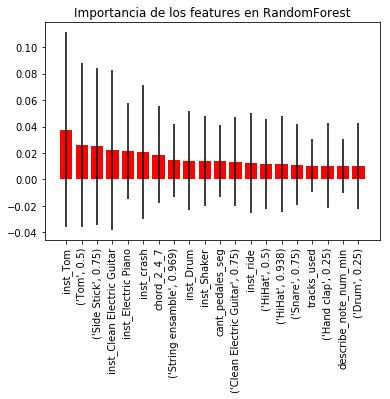

In [31]:
data_to_plot_top = data_to_plot.head(20)

plt.figure()
plt.title("Importancia de los features en RandomForest")
x_values = range(data_to_plot_top.shape[0])
y_values = data_to_plot_top.importance
y_err = data_to_plot_top.error
plt.bar(x_values, y_values, color="r", align="center", yerr=y_err )
plt.xticks(x_values, data_to_plot_top.feature, rotation=90)
plt.show()

In [32]:
data_to_plot.head(40)

,feature,importance,error
340,inst_Tom,0.037598,0.073557
349,"('Tom', 0.5)",0.026049,0.061874
403,"('Side Stick', 0.75)",0.024937,0.059531
358,inst_Clean Electric Guitar,0.022204,0.060274
295,inst_Electric Piano,0.021532,0.035909
342,inst_crash,0.020718,0.050862
196,chord_2_4_7,0.018859,0.036980
294,"('String ensamble', 0.969)",0.014435,0.027818
341,inst_Drum,0.014245,0.037094
366,inst_Shaker,0.014095,0.034006


## Referencias 

Cross Validation
https://scikit-learn.org/stable/modules/cross_validation.html

StratifiedKFold
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold

Grid Search
https://scikit-learn.org/stable/modules/grid_search.html#grid-search

ROC
https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html#sphx-glr-auto-examples-model-selection-plot-roc-crossval-py

BaggingClassifier
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html


In [34]:
sc = StandardScaler()
X_sc = sc.fit_transform(X)

In [40]:
from sklearn.decomposition import PCA
componentes_pca = 10
pca_X = PCA(n_components=componentes_pca)
pca_X.fit(X_sc)

X_pca_loadings = pd.DataFrame(pca_X.components_.T, index=X.columns, columns=['PC' + str(col) for col in range(componentes_pca)])
X_pca_loadings

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
cant_time_signatures,-0.003809,0.001453,0.020652,0.005234,0.011849,0.005525,0.012998,0.001718,-0.017931,0.002296
bpm,0.049126,0.043335,-0.023335,0.049628,-0.025029,-0.007951,-0.013885,0.012245,-0.003318,0.012373
compases,0.003404,-0.036002,0.041442,0.041035,0.011276,-0.001419,0.007703,-0.008706,-0.031855,0.001926
cant_dist_chords,-0.013516,-0.099552,0.023675,0.063750,0.051496,0.012673,0.036988,-0.016573,-0.044751,0.011950
avg_notes_quantified,0.045807,-0.059128,-0.034019,0.090379,0.021633,0.047252,0.014058,-0.015977,-0.012017,-0.001861
...,...,...,...,...,...,...,...,...,...,...
first_time_signature_7/8,0.001405,0.000898,0.004989,0.000173,0.000086,-0.004013,-0.000533,0.008542,0.001577,-0.007807
first_time_signature_8/4,-0.003090,-0.007123,-0.006036,0.006142,0.011115,-0.000394,0.002697,-0.000645,-0.000632,-0.003917
first_time_signature_8/8,0.003256,0.003673,-0.000194,0.005652,0.005272,-0.000313,-0.008616,-0.004998,-0.000713,0.001164
first_time_signature_9/16,-0.003925,-0.000698,-0.000262,-0.001246,0.002818,-0.000469,0.002914,-0.000912,-0.005460,0.000639


In [41]:
X_pca = pd.DataFrame(pca_X.fit_transform(X_sc), columns=['PC' + str(col) for col in range(componentes_pca)],\
                      index=X.index)
X_pca.head()

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
0,-5.195966,0.094797,0.482833,-1.393042,-0.040107,-0.590810,-0.090461,-0.698443,-1.275579,-0.184980
1,-5.047478,0.119819,1.301962,-1.103916,-1.094096,-0.355424,-0.314056,-1.200236,-1.468225,-0.611546
2,-4.819605,0.395340,0.942392,-1.428640,-0.764968,-0.528228,-0.342690,-0.744883,-1.139074,-0.402275
3,-4.574375,0.493368,1.406961,-1.009557,-0.799627,-0.376366,-0.388850,-1.171272,-1.445172,-0.737836
4,-4.629921,-0.573290,1.570606,-0.784598,-0.537263,-0.379393,-0.392722,-1.914971,-2.087392,-0.922674


In [42]:
import plotly.express as px

x_coord = np.array(X_pca)[:,0].astype(float)
y_coord = np.array(X_pca)[:,1].astype(float)
z_coord = np.array(X_pca)[:,2].astype(float)    

marks_size = [2 for i in range(len(x_coord))]

fig = px.scatter_3d(x = x_coord, y = y_coord, z = z_coord, 
              color = data_raw["Genero"],
              opacity = 0.6,hover_name=data_raw['Grupo'] + data_raw['tema'])

fig.show()

In [38]:
data_raw.drop(data_raw[data_raw.cant_pedales_seg > 9999999].index,inplace=True)